In [1]:
#!usr/bin/python
import numpy as np
import HFStability
import matplotlib.pyplot as plt

#Each run is an instance of PyHEG
run = HFStability.PyHEG(rs=3.0, ndim=2, Nk=10)

## Reproducing figures 2.1 and 2.2 from pages 82, 83 of Guiliani & Vignale, Quantum Theory of the Electron Liquid (2005)


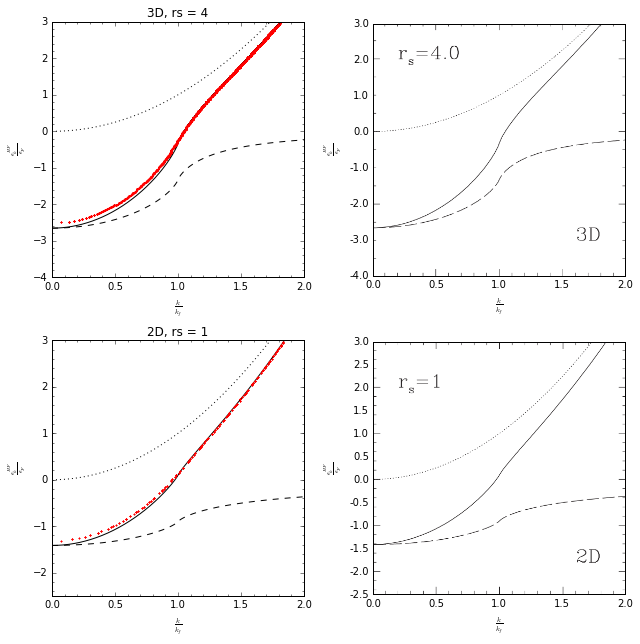

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.ticker import AutoMinorLocator
fig, axes = plt.subplots(2,2,figsize=(9,9))
def row_norm(ary):
    return np.sqrt((ary*ary).sum(axis=1))

#3D plot
run.ndim = 3
run.rs = 4.0
#run.fermi_energy = 0.5 * run.kf**2
x = np.linspace(0, 2.0 * run.kf, 500)
energy_x = np.array([run.analytic_energy(i) for i in x]) / run.fermi_energy
kinetic_x = np.array([0.5 * i**2 for i in x]) / run.fermi_energy
exch_x = np.array([run.analytic_exch(i) for i in x]) / run.fermi_energy
x = x / run.kf  #rescale for plot
axes[0,0].plot(x, energy_x, 'k-' , label='total energy')
axes[0,0].plot(x, kinetic_x, 'k:', label='kinetic energy')
axes[0,0].plot(x, exch_x, 'k--', label='exchange energy')
axes[0,0].set_title('3D, rs = 4')
axes[0,0].set_xlabel(r'$\frac{k}{k_f}$')
axes[0,0].set_ylabel(r'$\frac{\epsilon_k^{HF}}{\epsilon_F}$')
axes[0,0].set_xlim(0,2)
axes[0,0].set_ylim(-4.0,3.0)

#add minor ticks
minor_locator = AutoMinorLocator(5)
axes[0,0].yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
minor_locator = AutoMinorLocator(5)
axes[0,0].xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')

#Discretized 3D 
run.Nk = 50
run.calc_energy()
y = run.energies / run.fermi_energy
x = row_norm(run.states) / run.kf
axes[0,0].plot(x, y, 'r.', markersize=2)

#2D plot
run.ndim = 2
run.rs = 1.0
#run.fermi_energy = 0.5 * run.kf**2
x = np.linspace(0, 2.0 * run.kf, 500)
energy_x = np.array([run.analytic_energy(i) for i in x]) / run.fermi_energy
kinetic_x = np.array([0.5 * i**2 for i in x]) / run.fermi_energy
exch_x = np.array([run.analytic_exch(i) for i in x]) / run.fermi_energy
x = x / run.kf  #rescale for plot

axes[1,0].plot(x, energy_x, 'k-' , label='total energy')
axes[1,0].plot(x, kinetic_x, 'k:', label='kinetic energy')
axes[1,0].plot(x, exch_x, 'k--', label='exchange energy')
axes[1,0].set_title('2D, rs = 1')
axes[1,0].set_xlabel(r'$\frac{k}{k_f}$')
axes[1,0].set_ylabel(r'$\frac{\epsilon_k^{HF}}{\epsilon_F}$')
axes[1,0].set_xlim(0,2)
axes[1,0].set_ylim(-2.5,3)

#Discretized 2D 
run.Nk = 40
run.calc_energy()
y = run.energies / run.fermi_energy
x = row_norm(run.states) / run.kf
axes[1,0].plot(x, y, 'r.', markersize=2)
                                            
#add minor ticks
minor_locator = AutoMinorLocator(5)
axes[1,0].yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
minor_locator = AutoMinorLocator(5)
axes[1,0].xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')

#3D Figure
image = mpimg.imread("HF_singleparticleenergy_3D_Guiliani2005_fig2.1_cropped.png")
ntix = 5
xlabels = np.linspace(0,2,ntix)
xtix = np.linspace(0, image.shape[0], ntix)
ntix = 8
ytix = np.linspace(0, image.shape[1], ntix)
ylabels = np.linspace(-4,3,ntix)
axes[0,1].axis('on')
axes[0,1].imshow(image[::-1,:,:])
axes[0,1].set_xticks(xtix,minor=False)
axes[0,1].set_xticklabels(xlabels)
axes[0,1].set_xlim(0,image.shape[0])
axes[0,1].set_yticks(ytix)
axes[0,1].set_yticklabels(ylabels)
axes[0,1].set_ylim(0,image.shape[1])
axes[0,1].tick_params(top='off', bottom='off', left='off', right='off')
axes[0,1].set_xlabel(r'$\frac{k}{k_f}$')
axes[0,1].set_ylabel(r'$\frac{\epsilon_k^{HF}}{\epsilon_F}$')


#2D Figure
image = mpimg.imread("HF_singleparticleenergy_2D_Guiliani2005_fig2.2_cropped.png")
ntix = 5
xlabels = np.linspace(0,2,ntix)
xtix = np.linspace(0, image.shape[0], ntix)
ntix = 12
ytix = np.linspace(0, image.shape[1], ntix)
ylabels = np.linspace(-2.5,3,ntix)
axes[1,1].axis('on')
axes[1,1].imshow(image[::-1,:,:])
axes[1,1].set_xticks(xtix,minor=False)
axes[1,1].set_xticklabels(xlabels)
axes[1,1].set_xlim(0,image.shape[0])
axes[1,1].set_yticks(ytix)
axes[1,1].set_yticklabels(ylabels)
axes[1,1].set_ylim(0,image.shape[1])
axes[1,1].tick_params(top='off', bottom='off', left='off', right='off')
axes[1,1].set_xlabel(r'$\frac{k}{k_f}$')
axes[1,1].set_ylabel(r'$\frac{\epsilon_k^{HF}}{\epsilon_F}$')

plt.tight_layout()
plt.show()